<a href="https://colab.research.google.com/github/ylee64/dl-hw2/blob/master/homework2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [3]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 71.4MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x56a30000 @  0x7fce1ed4c2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 1.2MB/s 
    100% |████████████████████████████████| 2.0MB 5.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: True


In [4]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [5]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'harry_potter/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'harry_potter.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
import pt_util
os.chdir('/content')

/gdrive/My Drive/colab_files/homework2
harry_potter  pt_util.py  __pycache__


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
sys.path.append(BASE_PATH)
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    separator = " "
    data = separator.join(data.split())
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    processed_data = np.zeros((1, len(data)))
    vocab_ind = 0
    
    for data_ind, char in enumerate(data):
      # TODO Fill this in
      voc_value = vocab_ind;
      if char not in voc2ind:
        # place the voc 2 key pairing in the voc2ind
        voc2ind[char] = voc_value
        vocab_ind += 1
      else:
        # find the corresponding ind value for char
        voc_value = voc2ind[char]
      # put the correct vocab value into the processed data numpy array
      processed_data[0, data_ind] = voc_value  
    
    data = processed_data
    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[0][0 : int(len(data[0]) * .8)] # TODO Fill this in
    test_text = data[0][int(len(data[0]) * .8) : len(data[0])] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        dataset = dataset['tokens']
        dataset = dataset[0 : len(dataset) - len(dataset)%batch_size]
        self.dataset = dataset

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        chunk_size = len(self.dataset)/self.batch_size
        exact_num_seq = float(chunk_size)/self.sequence_length
        return math.ceil(exact_num_seq)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # length of data should be sequence_length + 1 starting at idx
        # unless oob
        end_index = idx + self.sequence_length
        if (end_index < len(self.dataset)):
          data = self.dataset[idx : end_index + 1]
        else: 
          data = self.dataset[idx : len(self.dataset)]
        data = torch.LongTensor(data)
        
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
BEAM_WIDTH = 10

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        outputs = []
        # Initializes the beam list.
        beams = [([], output, hidden, 0)]
        
        for ii in range(sequence_length):

            if sampling_strategy == 'max':
                # TODO max sampling strategy
                max_sample = torch.argmax(output, 1)
                outputs.append(max_sample.item())
                output, hidden = model.inference(max_sample, hidden)

            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.
                sample = torch.multinomial(output, 1)
                outputs.append(sample.item())
                output, hidden = model.inference(sample, hidden)

            elif sampling_strategy == 'beam':
                branch_beams = []
                for beam in beams:
                    beam_outputs = beam[0]
                    beam_output = beam[1]
                    beam_hidden = beam[2]
                    beam_score = beam[3]
                    
                    # take a BEAM_WIDTH number of samples from the beam_output
                    samples = torch.multinomial(beam_output, BEAM_WIDTH, replacement=True)
                  
                    for sample in samples[0]:
                        beam_outputs.append(sample.item())
                        beam_output, beam_hidden = model.inference(sample, beam_hidden)
                        sample_score = beam_output[0][sample.item()].item()
                        beam_score += math.log(sample_score)
                        branch_beam = (beam_outputs, beam_output, beam_hidden, beam_score)
                        branch_beams.append(branch_beam)
                    
                    beams = sorted(branch_beams, key=lambda beam: beam[3], reverse = True)
                    
                    # throwing out all but the top N beams
                    if len(beams) >= BEAM_WIDTH:
                        beams = beams[0 : BEAM_WIDTH]
                outputs = beams[0][0]
                
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    train_loader.dataset.vocab.array_to_words(data[0]),
                    train_loader.dataset.vocab.array_to_words(label[0]),
                    train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	dkXX,d::t,,,,`o hhXdMMM``Xd``RttJ ,,tt```qpXRXXXXYYhYhhhhRR,,?YYY,??,,`,hYYY'':hh:'quXX??,,J??````Y`



Test set: Average loss: 7.5143, Accuracy: 137/4900 (3%)

Train Epoch: 0 [0/195 (0%)]	Loss: 7.770797
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ntee    eeeeeee ee         t   eee ee e    eeee eeeeeeeee     eee eee   eeee   eeee    ee   eeet eet



Test set: Average loss: 22.5601, Accuracy: 888/4900 (18%)

Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/000.pt

generated sample	 Harry Potter e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e

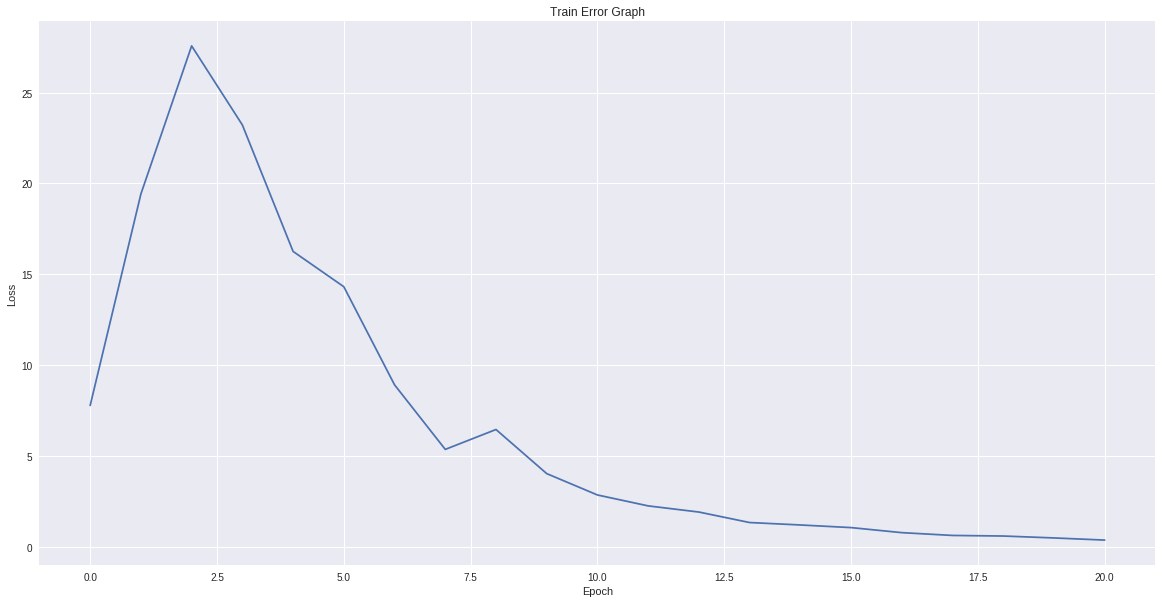

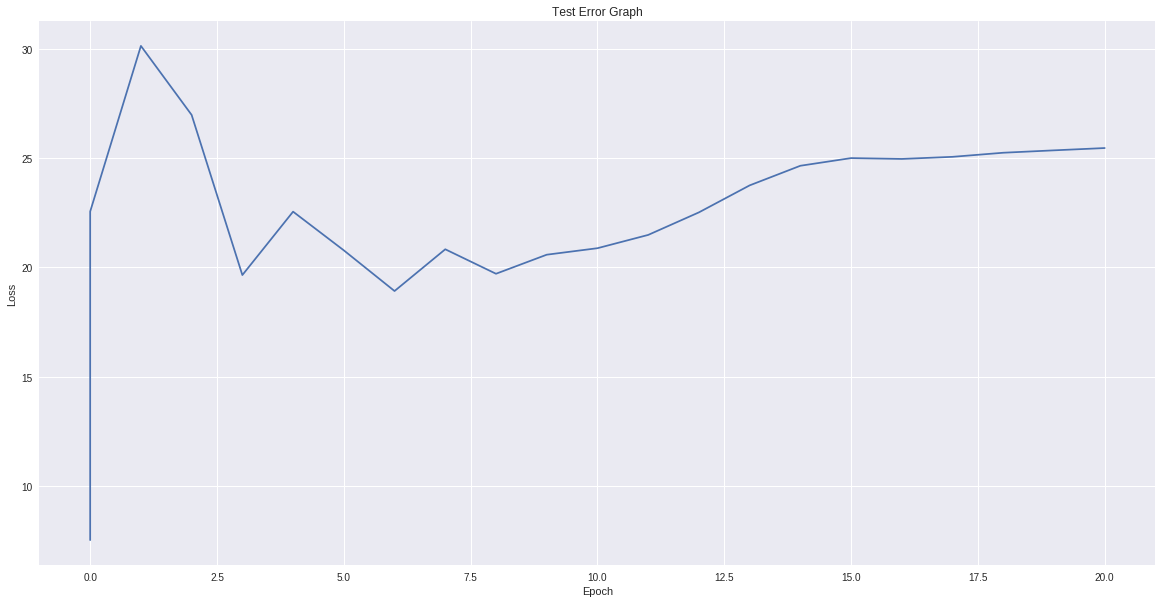

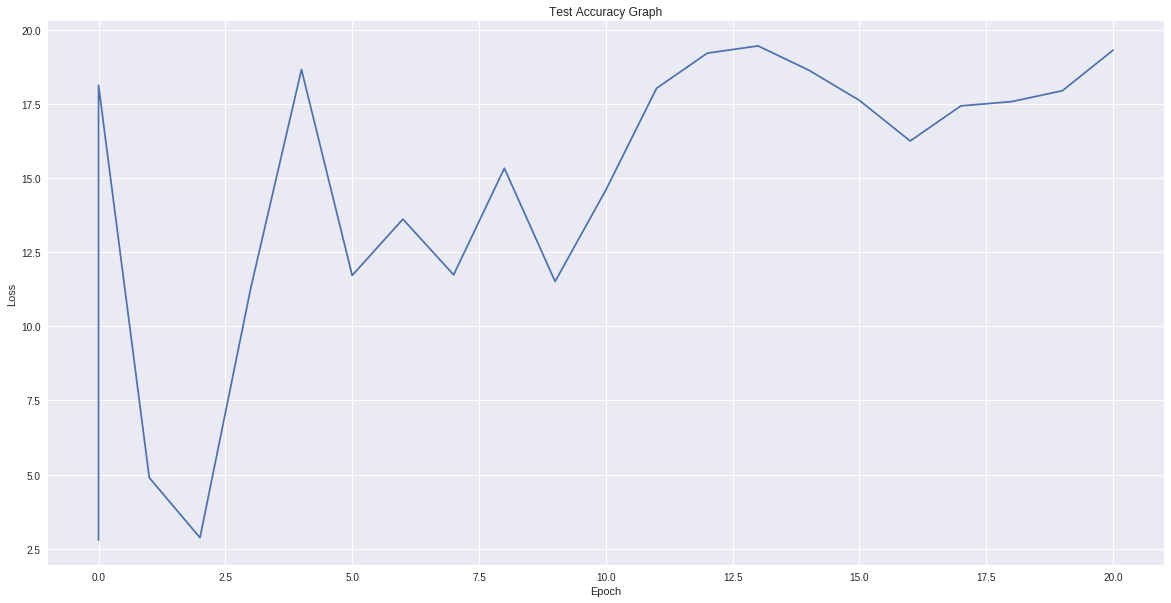

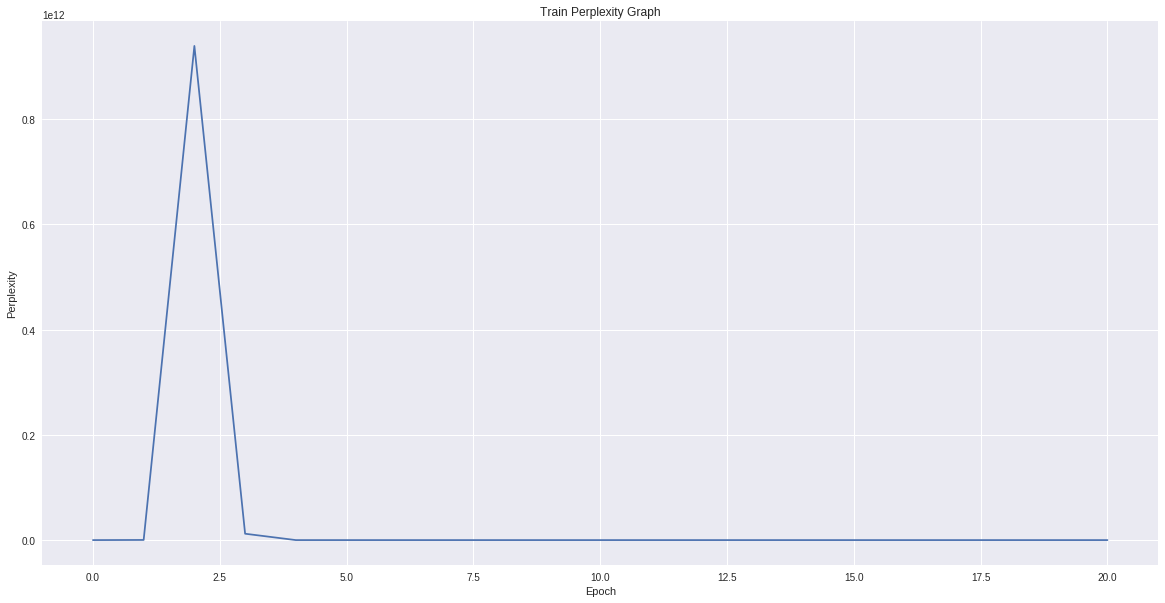

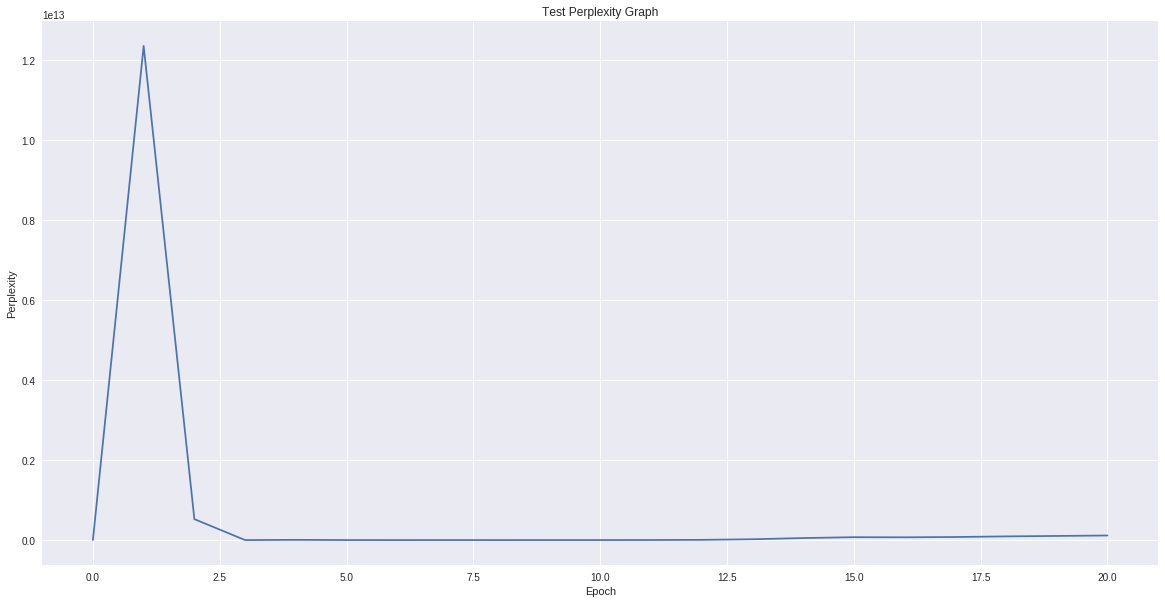

Saving final model
Saved /gdrive/My Drive/colab_files/homework2/harry_potter/checkpoints/020.pt



In [66]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 256
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'


data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
start_epoch = 0#model.load_last_model(DATA_PATH + 'checkpoints')

train_losses, test_losses, test_accuracies = [], [], []#pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        seed_words = 'Harry Potter'
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        # TODOOOOOOO change back to beam when beam is implemented
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    pt_util.plot([e[0] for e in train_losses], [l[1] for l in train_losses], 'Train Error Graph', 'Epoch', 'Loss')
    pt_util.plot([e[0] for e in test_losses], [l[1] for l in test_losses], 'Test Error Graph', 'Epoch', 'Loss')
    pt_util.plot([e[0] for e in test_accuracies], [l[1] for l in test_accuracies], 'Test Accuracy Graph', 'Epoch', 'Loss')
    pt_util.plot([e[0] for e in train_losses], [math.exp(l[1]) for l in train_losses], 'Train Perplexity Graph', 'Epoch', 'Perplexity')
    pt_util.plot([e[0] for e in test_losses], [math.exp(l[1]) for l in test_losses], 'Test Perplexity Graph', 'Epoch', 'Perplexity')
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)


#Part 7: Experiments

In [67]:
seed_words = 'Harry Potter and the'
sequence_length = 200

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

generated with max	 Harry Potter and therererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererere
generated with sample	 Harry Potter and therorerererere t Mrangre Mrererere Mrermbere oringrerere Mrangrerang t Mro t t t orang t t So Mrerangrerererangererere t o Mrerererererererererangrererere So t t t t t t t t wereringrangrererangre Mrery
generated with sample	 Harry Potter and there t Mrangererererery t o o D Mrerermberererererank t t o t t o t Mrangrererererangrerererangran anmbererangrangrouct o o we t t angrangry t Mrere t Mrerererferere t t t o Mrerangrererererers o t wer}
generated with sample	 Harry Potter and thererangrerererangrerangrerererere t t t Drerslangrerererangrererererererery t t t t t t t o Mriverfere t anmberererangrerangreryo o t Mreringry t Sorangrerere Mrerererangrmberererangrereringreran St t 
generated with sample	 Harr

#Part 8: Other things
Choose **two** of the following to try. It will probably be beneficial to create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
2. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
3. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
4. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
5. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called homework2_python.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

2. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
3. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

4. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
5. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    